<a href="https://colab.research.google.com/github/Alan240124/Alan/blob/main/Matricas(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class HeartDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = Image.open(image_path).convert("L")  # Converter para grayscale
        mask = Image.open(mask_path).convert("L")    # Converter para grayscale

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


# Diretórios das imagens e máscaras
image_dir = '/content/drive/MyDrive/Coracao_DataSet/images'  # Substitua pelo caminho real
mask_dir = '/content/drive/MyDrive/Coracao_DataSet/masks'    # Substitua pelo caminho real

# Transformação (exemplo: converter para tensor)
#transform = transforms.ToTensor()
# Transforma as imagens para tensor e normaliza
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Redimensione conforme necessário
    transforms.ToTensor(),
])

# Criação do dataset e do DataLoader
dataset = HeartDataset(image_dir, mask_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Exibir algumas informações do dataset
print(f"Total de imagens no dataset: {len(dataset)}")

# Exemplo de iteração pelo DataLoader
for images, masks in dataloader:
    print(f"Tamanho do batch de imagens: {images.shape}")
    print(f"Tamanho do batch de máscaras: {masks.shape}")
    break  # Apenas um batch para demonstração

Total de imagens no dataset: 8
Tamanho do batch de imagens: torch.Size([4, 1, 256, 256])
Tamanho do batch de máscaras: torch.Size([4, 1, 256, 256])


In [3]:
import torch.nn as nn
import torch

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(1, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.conv_last = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool1(e1))
        e3 = self.encoder3(self.pool2(e2))
        e4 = self.encoder4(self.pool3(e3))

        b = self.bottleneck(self.pool4(e4))

        d4 = self.upconv4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.decoder4(d4)
        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.decoder3(d3)
        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.decoder2(d2)
        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.decoder1(d1)

        return torch.sigmoid(self.conv_last(d1))

# Inicializar o modelo e definir o otimizador e a função de perda
model = UNet()
criterion = nn.BCELoss()  # Usamos BCELoss para segmentação binária
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [4]:
# Configuração do dispositivo (GPU se disponível)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Loop de treinamento
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader)}")

    # Salva o modelo após cada epoch
    torch.save(model.state_dict(), f"unet_epoch_{epoch+1}.pth")

Epoch [1/10], Loss: 0.7089537978172302
Epoch [2/10], Loss: 0.5999974310398102
Epoch [3/10], Loss: 12.463085651397705
Epoch [4/10], Loss: 0.5618598163127899
Epoch [5/10], Loss: 0.5213252305984497
Epoch [6/10], Loss: 0.5090392380952835
Epoch [7/10], Loss: 0.4318566620349884
Epoch [8/10], Loss: 0.3051586151123047
Epoch [9/10], Loss: 0.24109125137329102
Epoch [10/10], Loss: 0.16502097994089127


In [5]:
import torch

# Configuração do dispositivo (GPU se disponível)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Loop de treinamento
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, masks in dataloader:
        # Movendo dados para o dispositivo
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass e otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Acumulando a perda para monitoramento
        epoch_loss += loss.item()

    # Exibindo a perda média por epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(dataloader)}")

    # Salvando o modelo após cada epoch
    torch.save(model.state_dict(), f"unet_epoch_{epoch+1}.pth")

# Função para calcular o coeficiente DICE
def dice_coefficient(pred, target, epsilon=1e-6):
    intersection = (pred * target).sum()
    return (2. * intersection + epsilon) / (pred.sum() + target.sum() + epsilon)

# Avaliação com uma batch do DataLoader
model.eval()
with torch.no_grad():
    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        # Predições do modelo
        outputs = model(images)

        # Cálculo do coeficiente DICE
        dice = dice_coefficient(outputs, masks)
        print("DICE coefficient:", dice.item())
        break  # Apenas para a primeira batch


Epoch [1/10], Loss: 0.13432731479406357
Epoch [2/10], Loss: 0.11379203572869301
Epoch [3/10], Loss: 0.09932814538478851
Epoch [4/10], Loss: 0.08836030960083008
Epoch [5/10], Loss: 0.08502932265400887
Epoch [6/10], Loss: 0.08461902290582657
Epoch [7/10], Loss: 0.08303288742899895
Epoch [8/10], Loss: 0.07740835100412369
Epoch [9/10], Loss: 0.06910497322678566
Epoch [10/10], Loss: 0.08744993433356285
DICE coefficient: 0.8946191668510437


In [6]:
def dice_coefficient(pred, target, epsilon=1e-6):
    intersection = (pred * target).sum()
    return (2. * intersection + epsilon) / (pred.sum() + target.sum() + epsilon)

# Exemplo de uso com uma batch do DataLoader
model.eval()
with torch.no_grad():
    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        dice = dice_coefficient(outputs, masks)
        print("DICE coefficient:", dice.item())
        break  # Apenas para uma batch

DICE coefficient: 0.8801752924919128


In [7]:
import torch
import numpy as np

# Função de cálculo do DICE coefficient
def dice_coefficient(pred, target, epsilon=1e-6):
    pred = (pred > 0.5).float()  # Binarizar a predição
    target = (target > 0.5).float()  # Binarizar a máscara
    intersection = (pred * target).sum()  # Calcular a interseção
    return (2. * intersection + epsilon) / (pred.sum() + target.sum() + epsilon)  # Fórmula do DICE

# Função de cálculo da Intersection over Union (IoU)
def iou_score(pred, target, epsilon=1e-6):
    pred = (pred > 0.5).float()
    target = (target > 0.5).float()
    intersection = (pred * target).sum()  # Interseção
    union = pred.sum() + target.sum() - intersection  # União
    return (intersection + epsilon) / (union + epsilon)  # Fórmula do IoU

# Função de cálculo da Accuracy
def accuracy_score(pred, target):
    pred = (pred > 0.5).float()  # Binarizar a predição
    target = (target > 0.5).float()  # Binarizar a máscara
    correct = (pred == target).sum()  # Contar acertos
    total = target.numel()  # Total de pixels
    return correct / total  # Proporção de acertos

# Exemplo de uso com uma batch do DataLoader
model.eval()  # Coloca o modelo em modo de avaliação
with torch.no_grad():  # Desliga o cálculo de gradientes
    for images, masks in dataloader:  # Loop sobre as batches
        images = images.to(device)  # Mover para o dispositivo (GPU ou CPU)
        masks = masks.to(device)

        # Passando as imagens pela rede
        outputs = model(images)

        # Calcular as métricas
        dice = dice_coefficient(outputs, masks)  # DICE coefficient
        iou = iou_score(outputs, masks)  # IoU
        accuracy = accuracy_score(outputs, masks)  # Accuracy

        # Exibindo os resultados
        print(f"DICE coefficient: {dice.item():.4f}")
        print(f"IoU score: {iou.item():.4f}")
        print(f"Accuracy: {accuracy.item():.4f}")

        break  # Apenas para uma batch, remova esta linha para calcular para todas as batches


DICE coefficient: 0.8726
IoU score: 0.7739
Accuracy: 0.9656


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MeanIoU

# Função para carregar o dataset
def load_data(images_path, masks_path, img_size=(128, 128)):
    images = []
    masks = []

    for img_name in sorted(os.listdir(images_path)):
        img = tf.keras.preprocessing.image.load_img(os.path.join(images_path, img_name), target_size=img_size)
        img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        images.append(img)

    for mask_name in sorted(os.listdir(masks_path)):
        mask = tf.keras.preprocessing.image.load_img(os.path.join(masks_path, mask_name), color_mode='grayscale', target_size=img_size)
        mask = tf.keras.preprocessing.image.img_to_array(mask) / 255.0
        masks.append(mask)

    images = np.array(images, dtype=np.float32)
    masks = np.array(masks, dtype=np.float32)

    return train_test_split(images, masks, test_size=0.2, random_state=42)

# Função para definir o modelo CNN
def create_cnn_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu'),
        layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu'),
        layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', activation='sigmoid')
    ])
    return model

# Criar a métrica MeanIoU fora da função iou_metric
metric = MeanIoU(num_classes=2)

# Função de métrica personalizada (usando MeanIoU)
def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    metric.update_state(y_true, y_pred)
    return metric.result()

# Função para monitorar o treinamento
def get_callbacks():
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    return [early_stopping]

# Função principal de treinamento
def main(images_path, masks_path):
    # Carregar dados
    X_train, X_val, y_train, y_val = load_data(images_path, masks_path)

    # Definir modelo
    input_shape = X_train.shape[1:]
    model = create_cnn_model(input_shape)

    # Compilar modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[iou_metric])

    # Treinar modelo
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=50,
                        batch_size=8,
                        callbacks=get_callbacks())

    # Avaliar o modelo
    val_loss, val_iou = model.evaluate(X_val, y_val)
    print(f"Validation IoU: {val_iou:.4f}")

    return model, history

# Caminhos para as pastas de imagens e máscaras
images_path = '/content/drive/MyDrive/Coracao_DataSet/images'
masks_path = '/content/drive/MyDrive/Coracao_DataSet/masks'

# Executar o treinamento
if __name__ == "__main__":
    model, history = main(images_path, masks_path)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - iou_metric: 0.3634 - loss: 0.6926 - val_iou_metric: 0.3804 - val_loss: 0.6903
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - iou_metric: 0.4025 - loss: 0.6903 - val_iou_metric: 0.4079 - val_loss: 0.6864
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - iou_metric: 0.4182 - loss: 0.6865 - val_iou_metric: 0.4207 - val_loss: 0.6796
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step - iou_metric: 0.4263 - loss: 0.6799 - val_iou_metric: 0.4277 - val_loss: 0.6687
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step - iou_metric: 0.4311 - loss: 0.6693 - val_iou_metric: 0.4319 - val_loss: 0.6524
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step - iou_metric: 0.4341 - loss: 0.6533 - val_iou_metric: 0.4346 - val_loss: 0.6322
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step - iou_metric: 0.4361 - loss: 0.6333 - val_iou_metric: 0.4364 - val_loss: 0.6181
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step - iou_metric: 0.4373 - loss: 0.6182 - val_iou_metric: 

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6243 - loss: 0.6925
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step - accuracy: 0.6532 - loss: 0.6890
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step - accuracy: 0.6845 - loss: 0.6816
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step - accuracy: 0.6532 - loss: 0.6702
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step - accuracy: 0.6803 - loss: 0.6480
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step - accuracy: 0.6803 - loss: 0.6271
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step - accuracy: 0.6845 - loss: 0.6368
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6911 - loss: 0.6116
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step - accuracy: 0.6865 - loss: 0.6047
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6911 - loss: 0.5925
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


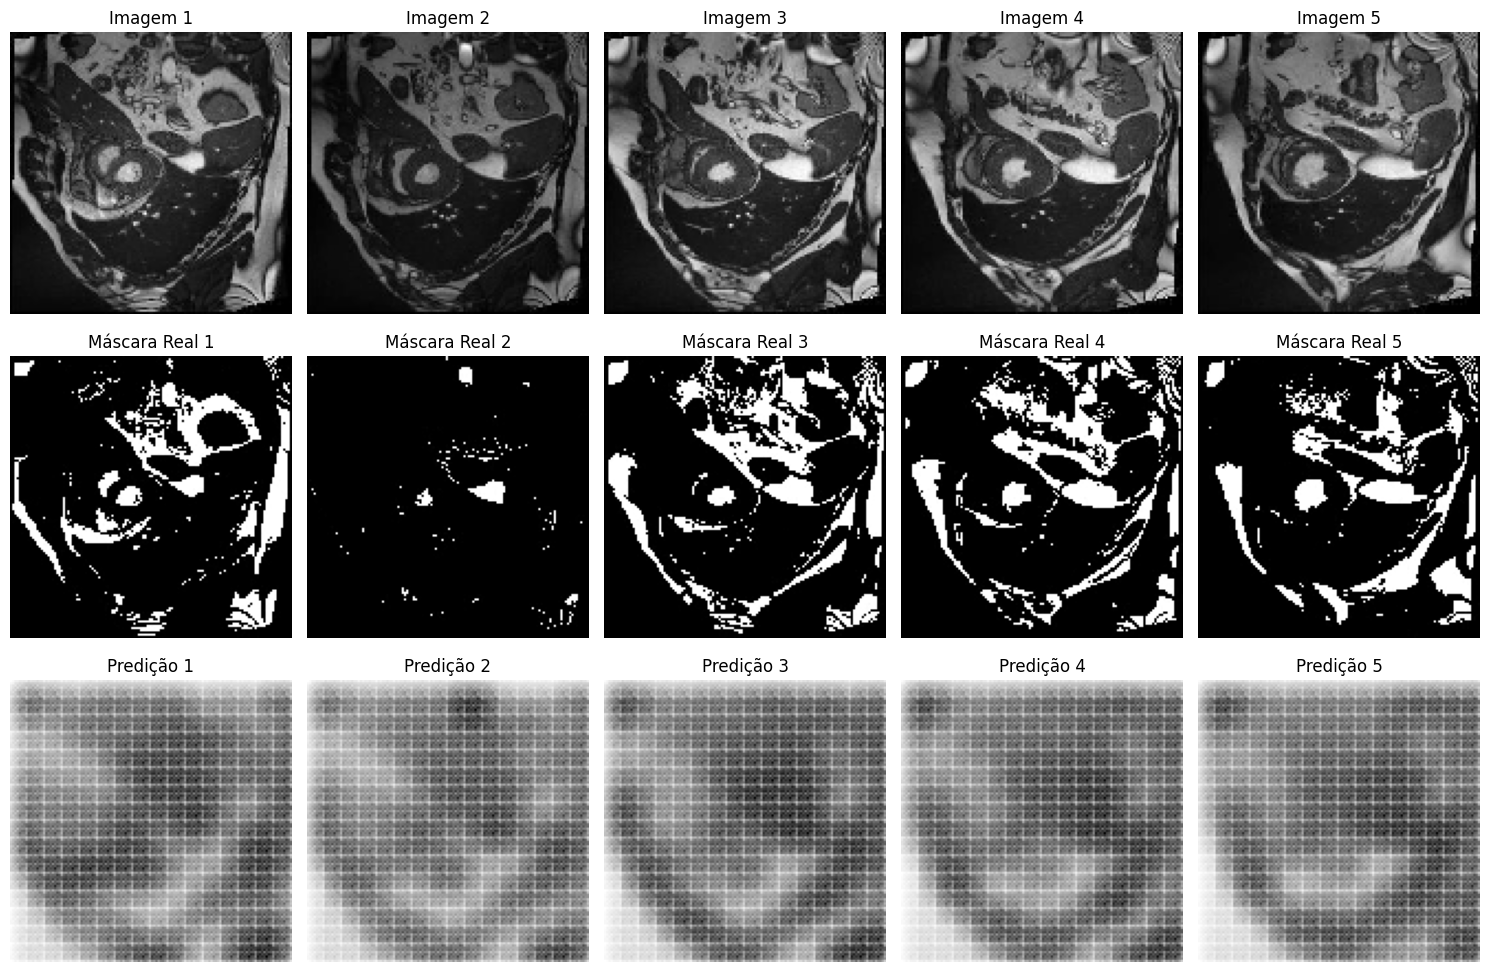

In [9]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

# Função para carregar e pré-processar as imagens e máscaras
def data(images_path, masks_path, img_size=(128, 128)):
    """
    Carrega e pré-processa as imagens e máscaras para segmentação.

    Parameters:
    - images_path: Caminho das imagens.
    - masks_path: Caminho das máscaras.
    - img_size: Tamanho de redimensionamento das imagens.

    Returns:
    - images: Numpy array com as imagens carregadas e normalizadas.
    - masks: Numpy array com as máscaras carregadas e normalizadas.
    """

    images = []
    masks = []

    for img_name in sorted(os.listdir(images_path)):
        # Carregar a imagem
        img = load_img(os.path.join(images_path, img_name), target_size=img_size)
        img = img_to_array(img) / 255.0  # Normalizar a imagem
        images.append(img)

    for mask_name in sorted(os.listdir(masks_path)):
        # Carregar a máscara
        mask = load_img(os.path.join(masks_path, mask_name), color_mode='grayscale', target_size=img_size)
        mask = img_to_array(mask) / 255.0  # Normalizar a máscara
        masks.append(mask)

    # Converter para numpy arrays
    images = np.array(images, dtype=np.float32)
    masks = np.array(masks, dtype=np.float32)

    # Adicionar a dimensão extra para a máscara (se necessário)
    if len(masks.shape) == 3:
        masks = np.expand_dims(masks, axis=-1)

    return images, masks

# DataLoader para carregar o dataset em lotes
class SegmentationDataLoader(Sequence):
    def __init__(self, images_path, masks_path, batch_size=8, img_size=(128, 128), shuffle=True):
        self.images_path = images_path
        self.masks_path = masks_path
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle

        self.images, self.masks = data(images_path, masks_path, img_size)
        self.indices = np.arange(len(self.images))
        self.on_epoch_end()  # Embaralhar os dados inicialmente

    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = self.images[batch_indices]
        batch_masks = self.masks[batch_indices]
        return batch_images, batch_masks

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# Função para definir o modelo CNN de segmentação
def create_cnn_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu'),
        layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu'),
        layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu'),

        layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')
    ])
    return model

# Função para treinar o modelo
def train_and_evaluate_model(images_path, masks_path, img_size=(128, 128), batch_size=8, epochs=50):
    # Criar o DataLoader
    train_loader = SegmentationDataLoader(images_path, masks_path, batch_size=batch_size, img_size=img_size)

    # Definir o modelo
    input_shape = (img_size[0], img_size[1], 3)  # 3 canais para RGB
    model = create_cnn_model(input_shape)

    # Compilar o modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Treinamento
    history = model.fit(train_loader, epochs=epochs)

    return model, history

# Função para visualizar as previsões
def visualize_predictions(model, images_path, masks_path, img_size=(128, 128)):
    # Carregar as primeiras 5 imagens e máscaras
    images, masks = data(images_path, masks_path, img_size)

    # Prever as máscaras para as primeiras 5 imagens
    preds = model.predict(images[:5])

    plt.figure(figsize=(15, 10))

    for i in range(5):
        plt.subplot(3, 5, i+1)
        plt.imshow(images[i])
        plt.title(f"Imagem {i+1}")
        plt.axis('off')

        plt.subplot(3, 5, i+6)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title(f"Máscara Real {i+1}")
        plt.axis('off')

        plt.subplot(3, 5, i+11)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title(f"Predição {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Função principal para treinar, avaliar e visualizar o modelo
def main():
    # Caminhos para as pastas de imagens e máscaras
    images_path = '/content/drive/MyDrive/DataSet3/images'  # Substitua pelo caminho da sua pasta de imagens
    masks_path = '/content/drive/MyDrive/DataSet3/masks'    # Substitua pelo caminho da sua pasta de máscaras

    # Treinamento e avaliação
    model, history = train_and_evaluate_model(images_path, masks_path, img_size=(128, 128), batch_size=8, epochs=10)

    # Visualizar as previsões
    visualize_predictions(model, images_path, masks_path, img_size=(128, 128))

if __name__ == "__main__":
    main()


In [13]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from PIL import Image

# Caminho do dataset
dataset_path = '/content/drive/MyDrive/Coracao_DataSet'

# Dataset personalizado
class HeartSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Máscaras em tons de cinza

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        mask = (mask > 0).float()  # Binarização da máscara
        return image, mask

# Transforma imagens para tensor
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Tamanho fixo para imagens e máscaras
    transforms.ToTensor()
])

# Diretórios das imagens e máscaras
image_dir = os.path.join(dataset_path, 'images')
mask_dir = os.path.join(dataset_path, 'masks')

# Divisão do dataset
dataset = HeartSegmentationDataset(image_dir, mask_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Dataloaders
batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}

# Modelo U-Net Simplificado
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Métricas de IoU e Dice
def iou_score(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()  # Binarizar predições
    intersection = (pred * target).sum((1, 2, 3))
    union = (pred + target).clamp(0, 1).sum((1, 2, 3))
    return ((intersection + smooth) / (union + smooth)).mean()

def dice_score(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()  # Binarizar predições
    intersection = (pred * target).sum((1, 2, 3))
    return ((2. * intersection + smooth) / (pred.sum((1, 2, 3)) + target.sum((1, 2, 3)) + smooth)).mean()

# Função de Treinamento
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, patience=5):
    best_model_wts = model.state_dict()
    best_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_iou = 0.0
            running_dice = 0.0

            for inputs, masks in tqdm(dataloaders[phase]):
                inputs, masks = inputs.to(device), masks.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs = F.interpolate(outputs, size=masks.shape[2:], mode='bilinear', align_corners=False)
                    loss = criterion(outputs, masks)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_iou += iou_score(outputs, masks).item() * inputs.size(0)
                running_dice += dice_score(outputs, masks).item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_iou = running_iou / len(dataloaders[phase].dataset)
            epoch_dice = running_dice / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} IoU: {epoch_iou:.4f} Dice: {epoch_dice:.4f}')

            if phase == 'val':
                scheduler.step(epoch_loss)

                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = model.state_dict()
                    early_stop_counter = 0
                else:
                    early_stop_counter += 1

        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

    model.load_state_dict(best_model_wts)
    return model

# Configurações do modelo e treinamento
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleUNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Treinar o modelo
model = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=50, patience=7)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0/49
----------


100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


train Loss: 0.8138 IoU: 0.1091 Dice: 0.1958


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


val Loss: 0.8262 IoU: 0.0522 Dice: 0.0992
Epoch 1/49
----------


100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


train Loss: 0.8080 IoU: 0.0565 Dice: 0.1068


100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


val Loss: 0.8197 IoU: 0.0703 Dice: 0.1313
Epoch 2/49
----------


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


train Loss: 0.8016 IoU: 0.0915 Dice: 0.1666


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


val Loss: 0.8114 IoU: 0.1587 Dice: 0.2738
Epoch 3/49
----------


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


train Loss: 0.7932 IoU: 0.1939 Dice: 0.3221


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


val Loss: 0.8003 IoU: 0.3047 Dice: 0.4666
Epoch 4/49
----------


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


train Loss: 0.7818 IoU: 0.3453 Dice: 0.5127


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


val Loss: 0.7861 IoU: 0.4391 Dice: 0.6098
Epoch 5/49
----------


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train Loss: 0.7673 IoU: 0.4561 Dice: 0.6232


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


val Loss: 0.7689 IoU: 0.4842 Dice: 0.6519
Epoch 6/49
----------


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


train Loss: 0.7501 IoU: 0.4987 Dice: 0.6625


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


val Loss: 0.7494 IoU: 0.5344 Dice: 0.6960
Epoch 7/49
----------


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train Loss: 0.7308 IoU: 0.5407 Dice: 0.6983


100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


val Loss: 0.7289 IoU: 0.5717 Dice: 0.7270
Epoch 8/49
----------


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


train Loss: 0.7111 IoU: 0.5723 Dice: 0.7250


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


val Loss: 0.7089 IoU: 0.5989 Dice: 0.7488
Epoch 9/49
----------


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


train Loss: 0.6919 IoU: 0.5993 Dice: 0.7476


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


val Loss: 0.6904 IoU: 0.6046 Dice: 0.7531
Epoch 10/49
----------


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train Loss: 0.6747 IoU: 0.5970 Dice: 0.7456


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


val Loss: 0.6749 IoU: 0.5982 Dice: 0.7480
Epoch 11/49
----------


100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


train Loss: 0.6609 IoU: 0.5884 Dice: 0.7383


100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


val Loss: 0.6634 IoU: 0.6138 Dice: 0.7603
Epoch 12/49
----------


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


train Loss: 0.6506 IoU: 0.6105 Dice: 0.7560


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


val Loss: 0.6550 IoU: 0.6118 Dice: 0.7586
Epoch 13/49
----------


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train Loss: 0.6434 IoU: 0.5980 Dice: 0.7464


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


val Loss: 0.6494 IoU: 0.6095 Dice: 0.7568
Epoch 14/49
----------


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


train Loss: 0.6386 IoU: 0.6039 Dice: 0.7508


100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


val Loss: 0.6468 IoU: 0.6248 Dice: 0.7688
Epoch 15/49
----------


100%|██████████| 2/2 [00:04<00:00,  2.34s/it]


train Loss: 0.6357 IoU: 0.6224 Dice: 0.7654


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


val Loss: 0.6435 IoU: 0.6066 Dice: 0.7545
Epoch 16/49
----------


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train Loss: 0.6339 IoU: 0.5919 Dice: 0.7411


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


val Loss: 0.6424 IoU: 0.6247 Dice: 0.7686
Epoch 17/49
----------


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


train Loss: 0.6325 IoU: 0.6241 Dice: 0.7669


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


val Loss: 0.6416 IoU: 0.6288 Dice: 0.7718
Epoch 18/49
----------


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


train Loss: 0.6315 IoU: 0.6184 Dice: 0.7626


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


val Loss: 0.6402 IoU: 0.6058 Dice: 0.7538
Epoch 19/49
----------


100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


train Loss: 0.6310 IoU: 0.6006 Dice: 0.7485


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


val Loss: 0.6405 IoU: 0.6334 Dice: 0.7752
Epoch 20/49
----------


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


train Loss: 0.6304 IoU: 0.6305 Dice: 0.7716


100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


val Loss: 0.6392 IoU: 0.6261 Dice: 0.7696
Epoch 21/49
----------


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


train Loss: 0.6298 IoU: 0.6153 Dice: 0.7599


100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


val Loss: 0.6387 IoU: 0.6227 Dice: 0.7670
Epoch 22/49
----------


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


train Loss: 0.6296 IoU: 0.6157 Dice: 0.7598


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


val Loss: 0.6390 IoU: 0.6349 Dice: 0.7763
Epoch 23/49
----------


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


train Loss: 0.6293 IoU: 0.6261 Dice: 0.7682


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


val Loss: 0.6382 IoU: 0.6286 Dice: 0.7715
Epoch 24/49
----------


100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


train Loss: 0.6289 IoU: 0.6216 Dice: 0.7645


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


val Loss: 0.6382 IoU: 0.6334 Dice: 0.7752
Epoch 25/49
----------


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


train Loss: 0.6287 IoU: 0.6291 Dice: 0.7705


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


val Loss: 0.6377 IoU: 0.6298 Dice: 0.7724
Epoch 26/49
----------


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


train Loss: 0.6286 IoU: 0.6201 Dice: 0.7634


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


val Loss: 0.6377 IoU: 0.6348 Dice: 0.7762
Epoch 27/49
----------


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


train Loss: 0.6284 IoU: 0.6318 Dice: 0.7727


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


val Loss: 0.6374 IoU: 0.6343 Dice: 0.7759
Epoch 28/49
----------


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


train Loss: 0.6282 IoU: 0.6247 Dice: 0.7672


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


val Loss: 0.6372 IoU: 0.6311 Dice: 0.7734
Epoch 29/49
----------


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


train Loss: 0.6281 IoU: 0.6268 Dice: 0.7684


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


val Loss: 0.6375 IoU: 0.6429 Dice: 0.7823
Epoch 30/49
----------


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


train Loss: 0.6280 IoU: 0.6324 Dice: 0.7728


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


val Loss: 0.6369 IoU: 0.6361 Dice: 0.7772
Epoch 31/49
----------


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train Loss: 0.6277 IoU: 0.6288 Dice: 0.7702


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


val Loss: 0.6371 IoU: 0.6435 Dice: 0.7827
Epoch 32/49
----------


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


train Loss: 0.6277 IoU: 0.6374 Dice: 0.7769


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


val Loss: 0.6366 IoU: 0.6322 Dice: 0.7743
Epoch 33/49
----------


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


train Loss: 0.6277 IoU: 0.6206 Dice: 0.7638


100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


val Loss: 0.6370 IoU: 0.6462 Dice: 0.7848
Epoch 34/49
----------


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


train Loss: 0.6276 IoU: 0.6442 Dice: 0.7822


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


val Loss: 0.6366 IoU: 0.6453 Dice: 0.7841
Epoch 35/49
----------


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


train Loss: 0.6274 IoU: 0.6327 Dice: 0.7729


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


val Loss: 0.6362 IoU: 0.6344 Dice: 0.7759
Epoch 36/49
----------


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


train Loss: 0.6274 IoU: 0.6292 Dice: 0.7703


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


val Loss: 0.6369 IoU: 0.6495 Dice: 0.7872
Epoch 37/49
----------


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


train Loss: 0.6271 IoU: 0.6433 Dice: 0.7813


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


val Loss: 0.6361 IoU: 0.6299 Dice: 0.7725
Epoch 38/49
----------


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


train Loss: 0.6272 IoU: 0.6234 Dice: 0.7661


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


val Loss: 0.6364 IoU: 0.6498 Dice: 0.7874
Epoch 39/49
----------


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


train Loss: 0.6270 IoU: 0.6469 Dice: 0.7842


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


val Loss: 0.6360 IoU: 0.6473 Dice: 0.7855
Epoch 40/49
----------


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


train Loss: 0.6267 IoU: 0.6390 Dice: 0.7781


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


val Loss: 0.6357 IoU: 0.6375 Dice: 0.7782
Epoch 41/49
----------


100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


train Loss: 0.6268 IoU: 0.6340 Dice: 0.7745


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


val Loss: 0.6360 IoU: 0.6508 Dice: 0.7882
Epoch 42/49
----------


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


train Loss: 0.6266 IoU: 0.6438 Dice: 0.7817


100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


val Loss: 0.6355 IoU: 0.6455 Dice: 0.7842
Epoch 43/49
----------


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


train Loss: 0.6264 IoU: 0.6402 Dice: 0.7789


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


val Loss: 0.6355 IoU: 0.6484 Dice: 0.7863
Epoch 44/49
----------


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


train Loss: 0.6263 IoU: 0.6428 Dice: 0.7810


100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


val Loss: 0.6354 IoU: 0.6480 Dice: 0.7860
Epoch 45/49
----------


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


train Loss: 0.6262 IoU: 0.6423 Dice: 0.7806


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


val Loss: 0.6355 IoU: 0.6536 Dice: 0.7902
Epoch 46/49
----------


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


train Loss: 0.6261 IoU: 0.6495 Dice: 0.7860


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


val Loss: 0.6351 IoU: 0.6456 Dice: 0.7843
Epoch 47/49
----------


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


train Loss: 0.6260 IoU: 0.6398 Dice: 0.7787


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


val Loss: 0.6351 IoU: 0.6503 Dice: 0.7877
Epoch 48/49
----------


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


train Loss: 0.6258 IoU: 0.6474 Dice: 0.7845


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


val Loss: 0.6350 IoU: 0.6520 Dice: 0.7890
Epoch 49/49
----------


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


train Loss: 0.6257 IoU: 0.6468 Dice: 0.7839


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

val Loss: 0.6348 IoU: 0.6493 Dice: 0.7870


In [20]:
import os
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm
from PIL import Image
import numpy as np

# Caminho do dataset
dataset_path = '/content/drive/MyDrive/Coracao_DataSet'

# Transformações para imagens e máscaras
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Dataset personalizado
class HeartSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Máscaras são em tons de cinza

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        mask = (mask > 0).float()  # Binarização da máscara
        return image, mask

# Diretórios das imagens e máscaras
image_dir = os.path.join(dataset_path, 'images')
mask_dir = os.path.join(dataset_path, 'masks')

# Divisão do dataset
dataset = HeartSegmentationDataset(image_dir, mask_dir, image_transform, mask_transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Dataloaders
batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}

# Modelo U-Net simples
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Métricas: IoU e Dice
def iou_score(pred, target, smooth=1e-6):
    pred = pred > 0.5  # Converte para binário
    target = target > 0.5
    intersection = (pred & target).float().sum((1, 2, 3))  # Somar nas dimensões do batch
    union = (pred | target).float().sum((1, 2, 3))
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()  # Retorna um valor escalar

def dice_score(pred, target, smooth=1e-6):
    pred = pred > 0.5
    target = target > 0.5
    intersection = (pred * target).float().sum((1, 2, 3))
    dice = (2 * intersection + smooth) / (pred.sum((1, 2, 3)) + target.sum((1, 2, 3)) + smooth)
    return dice.mean()

# Função de Treinamento com Parada Antecipada e Decaimento do Learning Rate
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, patience=5):
    best_model_wts = model.state_dict()
    best_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_iou = 0.0
            running_dice = 0.0

            for inputs, masks in tqdm(dataloaders[phase]):
                inputs, masks = inputs.to(device), masks.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, masks)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                preds = torch.sigmoid(outputs) > 0.5
                running_loss += loss.item() * inputs.size(0)
                running_iou += iou_score(preds, masks).item() * inputs.size(0)
                running_dice += dice_score(preds, masks).item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_iou = running_iou / len(dataloaders[phase].dataset)
            epoch_dice = running_dice / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} IoU: {epoch_iou:.4f} Dice: {epoch_dice:.4f}')

            # Estratégia de parada automática
            if phase == 'val':
                scheduler.step(epoch_loss)

                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = model.state_dict()
                    early_stop_counter = 0
                else:
                    early_stop_counter += 1

        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

    model.load_state_dict(best_model_wts)
    return model

# Configurações do modelo e treinamento
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.BCEWithLogitsLoss()  # Usando logits diretamente
optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Treinamento do modelo
model = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=50, patience=7)

# Salvando o modelo treinado
torch.save(model.state_dict(), 'modelo_heart_segmentation.pth')


Epoch 0/49
----------


100%|██████████| 2/2 [00:07<00:00,  3.79s/it]


train Loss: 0.8340 IoU: 0.2818 Dice: 0.4388


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


val Loss: 0.8174 IoU: 0.3077 Dice: 0.4698
Epoch 1/49
----------


100%|██████████| 2/2 [00:09<00:00,  4.65s/it]


train Loss: 0.8290 IoU: 0.2818 Dice: 0.4388


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


val Loss: 0.8112 IoU: 0.3077 Dice: 0.4698
Epoch 2/49
----------


100%|██████████| 2/2 [00:08<00:00,  4.41s/it]


train Loss: 0.8218 IoU: 0.2818 Dice: 0.4388


100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


val Loss: 0.8012 IoU: 0.3077 Dice: 0.4698
Epoch 3/49
----------


100%|██████████| 2/2 [00:07<00:00,  3.75s/it]


train Loss: 0.8101 IoU: 0.2818 Dice: 0.4388


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


val Loss: 0.7858 IoU: 0.3077 Dice: 0.4698
Epoch 4/49
----------


100%|██████████| 2/2 [00:09<00:00,  4.84s/it]


train Loss: 0.7924 IoU: 0.2818 Dice: 0.4388


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


val Loss: 0.7641 IoU: 0.3077 Dice: 0.4698
Epoch 5/49
----------


100%|██████████| 2/2 [00:08<00:00,  4.26s/it]


train Loss: 0.7676 IoU: 0.2818 Dice: 0.4388


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


val Loss: 0.7374 IoU: 0.3077 Dice: 0.4698
Epoch 6/49
----------


100%|██████████| 2/2 [00:08<00:00,  4.07s/it]


train Loss: 0.7384 IoU: 0.2818 Dice: 0.4388


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


val Loss: 0.7086 IoU: 0.3077 Dice: 0.4698
Epoch 7/49
----------


100%|██████████| 2/2 [00:09<00:00,  4.70s/it]


train Loss: 0.7082 IoU: 0.2818 Dice: 0.4388


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


val Loss: 0.6818 IoU: 0.3077 Dice: 0.4698
Epoch 8/49
----------


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


train Loss: 0.6818 IoU: 0.2818 Dice: 0.4388


100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


val Loss: 0.6628 IoU: 0.3077 Dice: 0.4698
Epoch 9/49
----------


100%|██████████| 2/2 [00:09<00:00,  4.78s/it]


train Loss: 0.6645 IoU: 0.2818 Dice: 0.4388


100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


val Loss: 0.6525 IoU: 0.3077 Dice: 0.4698
Epoch 10/49
----------


100%|██████████| 2/2 [00:09<00:00,  4.91s/it]


train Loss: 0.6550 IoU: 0.2818 Dice: 0.4388


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


val Loss: 0.6450 IoU: 0.3077 Dice: 0.4698
Epoch 11/49
----------


100%|██████████| 2/2 [00:07<00:00,  4.00s/it]


train Loss: 0.6476 IoU: 0.2818 Dice: 0.4388


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


val Loss: 0.6398 IoU: 0.3077 Dice: 0.4698
Epoch 12/49
----------


100%|██████████| 2/2 [00:08<00:00,  4.16s/it]


train Loss: 0.6427 IoU: 0.2818 Dice: 0.4388


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


val Loss: 0.6356 IoU: 0.3077 Dice: 0.4698
Epoch 13/49
----------


100%|██████████| 2/2 [00:09<00:00,  4.70s/it]


train Loss: 0.6386 IoU: 0.2818 Dice: 0.4388


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


val Loss: 0.6325 IoU: 0.3077 Dice: 0.4698
Epoch 14/49
----------


100%|██████████| 2/2 [00:07<00:00,  3.77s/it]


train Loss: 0.6363 IoU: 0.2818 Dice: 0.4388


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


val Loss: 0.6306 IoU: 0.3077 Dice: 0.4698
Epoch 15/49
----------


100%|██████████| 2/2 [00:08<00:00,  4.45s/it]


train Loss: 0.6346 IoU: 0.2818 Dice: 0.4388


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


val Loss: 0.6297 IoU: 0.3077 Dice: 0.4698
Epoch 16/49
----------


100%|██████████| 2/2 [00:09<00:00,  4.59s/it]


train Loss: 0.6335 IoU: 0.2818 Dice: 0.4388


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


val Loss: 0.6286 IoU: 0.3077 Dice: 0.4698
Epoch 17/49
----------


100%|██████████| 2/2 [00:07<00:00,  3.98s/it]


train Loss: 0.6328 IoU: 0.2818 Dice: 0.4388


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


val Loss: 0.6280 IoU: 0.3077 Dice: 0.4698
Epoch 18/49
----------


100%|██████████| 2/2 [00:09<00:00,  4.69s/it]


train Loss: 0.6322 IoU: 0.2818 Dice: 0.4388


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


val Loss: 0.6275 IoU: 0.3228 Dice: 0.4872
Epoch 19/49
----------


100%|██████████| 2/2 [00:08<00:00,  4.27s/it]


train Loss: 0.6318 IoU: 0.3072 Dice: 0.4694


100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


val Loss: 0.6269 IoU: 0.3728 Dice: 0.5423
Epoch 20/49
----------


100%|██████████| 2/2 [00:07<00:00,  3.83s/it]


train Loss: 0.6312 IoU: 0.3617 Dice: 0.5297


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


val Loss: 0.6264 IoU: 0.4316 Dice: 0.6025
Epoch 21/49
----------


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


train Loss: 0.6308 IoU: 0.4269 Dice: 0.5974


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


val Loss: 0.6259 IoU: 0.4819 Dice: 0.6499
Epoch 22/49
----------


100%|██████████| 2/2 [00:08<00:00,  4.10s/it]


train Loss: 0.6304 IoU: 0.4758 Dice: 0.6441


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


val Loss: 0.6256 IoU: 0.4957 Dice: 0.6625
Epoch 23/49
----------


100%|██████████| 2/2 [00:08<00:00,  4.19s/it]


train Loss: 0.6300 IoU: 0.4905 Dice: 0.6575


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


val Loss: 0.6250 IoU: 0.4985 Dice: 0.6650
Epoch 24/49
----------


100%|██████████| 2/2 [00:09<00:00,  4.67s/it]


train Loss: 0.6296 IoU: 0.4956 Dice: 0.6621


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


val Loss: 0.6248 IoU: 0.5076 Dice: 0.6731
Epoch 25/49
----------


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


train Loss: 0.6293 IoU: 0.5051 Dice: 0.6706


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val Loss: 0.6242 IoU: 0.5047 Dice: 0.6706
Epoch 26/49
----------


100%|██████████| 2/2 [00:08<00:00,  4.49s/it]


train Loss: 0.6291 IoU: 0.5021 Dice: 0.6679


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


val Loss: 0.6243 IoU: 0.5160 Dice: 0.6805
Epoch 27/49
----------


100%|██████████| 2/2 [00:08<00:00,  4.48s/it]


train Loss: 0.6288 IoU: 0.5145 Dice: 0.6788


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


val Loss: 0.6236 IoU: 0.5093 Dice: 0.6746
Epoch 28/49
----------


100%|██████████| 2/2 [00:07<00:00,  3.70s/it]


train Loss: 0.6287 IoU: 0.5070 Dice: 0.6722


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


val Loss: 0.6236 IoU: 0.5213 Dice: 0.6851
Epoch 29/49
----------


100%|██████████| 2/2 [00:09<00:00,  4.64s/it]


train Loss: 0.6284 IoU: 0.5221 Dice: 0.6854


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


val Loss: 0.6230 IoU: 0.5153 Dice: 0.6799
Epoch 30/49
----------


100%|██████████| 2/2 [00:08<00:00,  4.15s/it]


train Loss: 0.6285 IoU: 0.5123 Dice: 0.6769


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


val Loss: 0.6232 IoU: 0.5278 Dice: 0.6907
Epoch 31/49
----------


100%|██████████| 2/2 [00:07<00:00,  3.92s/it]


train Loss: 0.6283 IoU: 0.5299 Dice: 0.6920


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


val Loss: 0.6225 IoU: 0.5222 Dice: 0.6859
Epoch 32/49
----------


100%|██████████| 2/2 [00:09<00:00,  4.90s/it]


train Loss: 0.6280 IoU: 0.5180 Dice: 0.6818


100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


val Loss: 0.6223 IoU: 0.5234 Dice: 0.6870
Epoch 33/49
----------


100%|██████████| 2/2 [00:09<00:00,  4.92s/it]


train Loss: 0.6280 IoU: 0.5287 Dice: 0.6911


100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


val Loss: 0.6224 IoU: 0.5312 Dice: 0.6936
Epoch 34/49
----------


100%|██████████| 2/2 [00:07<00:00,  3.76s/it]


train Loss: 0.6274 IoU: 0.5272 Dice: 0.6897


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


val Loss: 0.6225 IoU: 0.5212 Dice: 0.6851
Epoch 35/49
----------


100%|██████████| 2/2 [00:09<00:00,  4.62s/it]


train Loss: 0.6278 IoU: 0.5233 Dice: 0.6863


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


val Loss: 0.6230 IoU: 0.5384 Dice: 0.6997
Epoch 36/49
----------


100%|██████████| 2/2 [00:08<00:00,  4.18s/it]


train Loss: 0.6276 IoU: 0.5366 Dice: 0.6978


100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


val Loss: 0.6220 IoU: 0.5245 Dice: 0.6878
Epoch 37/49
----------


100%|██████████| 2/2 [00:07<00:00,  3.88s/it]


train Loss: 0.6274 IoU: 0.5249 Dice: 0.6877


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


val Loss: 0.6220 IoU: 0.5357 Dice: 0.6974
Epoch 38/49
----------


100%|██████████| 2/2 [00:09<00:00,  4.64s/it]


train Loss: 0.6272 IoU: 0.5375 Dice: 0.6985


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


val Loss: 0.6216 IoU: 0.5298 Dice: 0.6925
Epoch 39/49
----------


100%|██████████| 2/2 [00:08<00:00,  4.00s/it]


train Loss: 0.6271 IoU: 0.5282 Dice: 0.6906


100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


val Loss: 0.6215 IoU: 0.5336 Dice: 0.6957
Epoch 40/49
----------


100%|██████████| 2/2 [00:08<00:00,  4.17s/it]


train Loss: 0.6269 IoU: 0.5367 Dice: 0.6977


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


val Loss: 0.6215 IoU: 0.5377 Dice: 0.6991
Epoch 41/49
----------


100%|██████████| 2/2 [00:09<00:00,  4.66s/it]


train Loss: 0.6268 IoU: 0.5350 Dice: 0.6964


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


val Loss: 0.6213 IoU: 0.5323 Dice: 0.6946
Epoch 42/49
----------


100%|██████████| 2/2 [00:07<00:00,  3.79s/it]


train Loss: 0.6266 IoU: 0.5343 Dice: 0.6958


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


val Loss: 0.6221 IoU: 0.5460 Dice: 0.7061
Epoch 43/49
----------


100%|██████████| 2/2 [00:08<00:00,  4.28s/it]


train Loss: 0.6269 IoU: 0.5429 Dice: 0.7030


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


val Loss: 0.6215 IoU: 0.5310 Dice: 0.6935
Epoch 44/49
----------


100%|██████████| 2/2 [00:09<00:00,  4.62s/it]


train Loss: 0.6270 IoU: 0.5318 Dice: 0.6937


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


val Loss: 0.6219 IoU: 0.5481 Dice: 0.7078
Epoch 45/49
----------


100%|██████████| 2/2 [00:07<00:00,  3.77s/it]


train Loss: 0.6269 IoU: 0.5473 Dice: 0.7066


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


val Loss: 0.6208 IoU: 0.5384 Dice: 0.6998
Epoch 46/49
----------


100%|██████████| 2/2 [00:09<00:00,  4.51s/it]


train Loss: 0.6265 IoU: 0.5373 Dice: 0.6983


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


val Loss: 0.6207 IoU: 0.5390 Dice: 0.7002
Epoch 47/49
----------


100%|██████████| 2/2 [00:09<00:00,  4.62s/it]


train Loss: 0.6263 IoU: 0.5414 Dice: 0.7018


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val Loss: 0.6209 IoU: 0.5446 Dice: 0.7049
Epoch 48/49
----------


100%|██████████| 2/2 [00:07<00:00,  3.81s/it]


train Loss: 0.6261 IoU: 0.5416 Dice: 0.7018


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


val Loss: 0.6207 IoU: 0.5368 Dice: 0.6984
Epoch 49/49
----------


100%|██████████| 2/2 [00:09<00:00,  4.58s/it]


train Loss: 0.6262 IoU: 0.5391 Dice: 0.6997


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

val Loss: 0.6213 IoU: 0.5511 Dice: 0.7103
